## FLIGHT STATUS PREDICTOR PROJECT

#### The goal of this project is to develop and deploy an ML model in which an end user can specify a set of features describing a commercial flight of interest and receive a categorical (yes or no) output indicating if the arrival time of that flight will be delayed more than fifteen minutes or not. 

### MODEL TRAINING & EVALUATION

In [4]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from imblearn.combine import SMOTETomek
from scipy.stats import boxcox, yeojohnson
import time
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [5]:
# Load the dataset with selected features and target variable
df_selected_features = pd.read_csv('selected_features.csv')

# Define the target variable
target = 'Arr_Delay_At_Least_15_Minutes'

# Split the dataset back into features and target variable
X = df_selected_features.drop(columns=[target])
y = df_selected_features[target]

# Check the loaded data
print(X.head())
print(y.head())

   Arr_Hour  Dep_Hour  Dep_Time_Day_Interaction  Destination_Airport_ID  \
0         7       6.0                    3000.0                 12889.0   
1        12      21.0                       0.0                 13198.0   
2        14      13.0                    2610.0                 10821.0   
3        17      15.0                    9030.0                 13487.0   
4        10      21.0                    8508.0                 10721.0   

   Distance_Group  Is_Weekend  Month  Month_Day  Number_of_Flights  \
0        2.079442    0.693147      5         13                  1   
1        1.791759    0.000000      5         22                  1   
2        1.098612    0.000000      5         17                  1   
3        1.791759    0.693147      6         18                  1   
4        1.609438    0.000000      6          9                  1   

   Origin_Airport_ID  Scheduled_Gate_to_Gate_Time  
0            14730.0                     5.497168  
1            14107.0    

In [6]:
print(df_selected_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742902 entries, 0 to 2742901
Data columns (total 12 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Arr_Hour                       int64  
 1   Dep_Hour                       float64
 2   Dep_Time_Day_Interaction       float64
 3   Destination_Airport_ID         float64
 4   Distance_Group                 float64
 5   Is_Weekend                     float64
 6   Month                          int64  
 7   Month_Day                      int64  
 8   Number_of_Flights              int64  
 9   Origin_Airport_ID              float64
 10  Scheduled_Gate_to_Gate_Time    float64
 11  Arr_Delay_At_Least_15_Minutes  int64  
dtypes: float64(7), int64(5)
memory usage: 251.1 MB
None


In [7]:
print(df_selected_features.head())

   Arr_Hour  Dep_Hour  Dep_Time_Day_Interaction  Destination_Airport_ID  \
0         7       6.0                    3000.0                 12889.0   
1        12      21.0                       0.0                 13198.0   
2        14      13.0                    2610.0                 10821.0   
3        17      15.0                    9030.0                 13487.0   
4        10      21.0                    8508.0                 10721.0   

   Distance_Group  Is_Weekend  Month  Month_Day  Number_of_Flights  \
0        2.079442    0.693147      5         13                  1   
1        1.791759    0.000000      5         22                  1   
2        1.098612    0.000000      5         17                  1   
3        1.791759    0.693147      6         18                  1   
4        1.609438    0.000000      6          9                  1   

   Origin_Airport_ID  Scheduled_Gate_to_Gate_Time  \
0            14730.0                     5.497168   
1            14107.0  

In [8]:
# Split data into training and test sets
start_time = time.time()
numerical_features = X.columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Data split took: %s seconds" % (time.time() - start_time))

Data split took: 1.0040862560272217 seconds


In [9]:
# Preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ])

# Fit the preprocessor on the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [10]:
# Ensure all data is numeric and there are no missing values
X_train_preprocessed = X_train_preprocessed.astype(np.float32, copy=False)
X_test_preprocessed = X_test_preprocessed.astype(np.float32, copy=False)

In [11]:
# Inspect the first few rows of the preprocessed data
print("Sample of X_test_preprocessed:")
print(X_test_preprocessed[:5])

Sample of X_test_preprocessed:
[[-0.8115006  -1.3643936   0.06422414  0.38017365  0.28975716  1.582973
   1.0560446  -0.8993095   0.         -0.8813404   0.11819851]
 [ 0.7463393   0.9076964   0.9170935  -0.8938286  -1.7159543  -0.6317227
  -1.0311764  -0.09783843  0.          0.16994782 -1.4806281 ]
 [-0.22731064 -0.12507178  1.1212763   0.5528863  -0.19869216  1.582973
   0.75787014 -1.4717889   0.          0.4433091  -0.30969533]
 [ 0.35687935  0.2880355   1.5115725  -1.3351325  -0.82841283  1.582973
  -0.73300207  0.8181285   0.         -0.8813404  -0.7018736 ]
 [ 1.5252594   1.733911    2.5668175  -1.2871932  -0.19869216  1.582973
   0.16152127 -1.5862848   0.          0.3780976  -0.21717446]]


In [12]:
# Check for non-numeric values and missing values
print("Data types in X_test_preprocessed after conversion:", X_test_preprocessed.dtype)
missing_values = np.isnan(X_test_preprocessed).sum()
print(f"Number of missing values: {missing_values}")

# If missing values exist, handle them appropriately
if missing_values > 0:
    print("There are missing values in the preprocessed data!")
else:
    print("No missing values in the preprocessed data.")

Data types in X_test_preprocessed after conversion: float32
Number of missing values: 0
No missing values in the preprocessed data.


In [13]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

start_time = time.time()

# Use a sample of the training data
sample_size = 10000
X_train_sample = X_train_preprocessed[:sample_size]
y_train_sample = y_train[:sample_size]

# Train RandomForest model
rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)
rf_model.fit(X_train_sample, y_train_sample)

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_sample, y_train_sample)

# Train Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train_sample, y_train_sample)

# Train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_sample, y_train_sample)

# Train LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_sample, y_train_sample)

print("Model training took: %s seconds" % (time.time() - start_time))

[LightGBM] [Info] Number of positive: 4952, number of negative: 5048
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1006
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495200 -> initscore=-0.019201
[LightGBM] [Info] Start training from score -0.019201
Model training took: 2.4067912101745605 seconds


In [14]:
# Model evaluation
start_time = time.time()

# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC: {roc_auc}')

    return y_pred_proba

# Evaluate RandomForest
print("RandomForest Model Evaluation:")
rf_proba = evaluate_model(rf_model, X_test_preprocessed, y_test)

# Evaluate Logistic Regression
print("Logistic Regression Model Evaluation:")
lr_proba = evaluate_model(lr_model, X_test_preprocessed, y_test)

# Evaluate Gradient Boosting
print("Gradient Boosting Model Evaluation:")
gb_proba = evaluate_model(gb_model, X_test_preprocessed, y_test)

# Evaluate XGBoost model
print("XGBoost Model Evaluation:")
xgb_proba = evaluate_model(xgb_model, X_test_preprocessed, y_test)

# Evaluate LightGBM model
print("LightGBM Model Evaluation:")
lgb_proba = evaluate_model(lgb_model, X_test_preprocessed, y_test)

print("Model evaluation took: %s seconds" % (time.time() - start_time))

RandomForest Model Evaluation:
Accuracy: 0.5973630147598987
Precision: 0.6022067519107196
Recall: 0.5736629115170075
F1 Score: 0.5875883856536571
ROC-AUC: 0.6330807205045288
Logistic Regression Model Evaluation:
Accuracy: 0.5955455985533585
Precision: 0.5951148695241898
Recall: 0.5978052426264173
F1 Score: 0.5964570222982067
ROC-AUC: 0.6266081977277044
Gradient Boosting Model Evaluation:
Accuracy: 0.6110528800669364
Precision: 0.6173855740661526
Recall: 0.5840752488242371
F1 Score: 0.600268649502324
ROC-AUC: 0.6516110460490582
XGBoost Model Evaluation:
Accuracy: 0.5950989917623833
Precision: 0.5986595508890309
Recall: 0.5770498377629516
F1 Score: 0.5876560994581188
ROC-AUC: 0.6288928475379832
LightGBM Model Evaluation:
Accuracy: 0.6099099312590119
Precision: 0.6177148167527001
Recall: 0.5767545298771374
F1 Score: 0.5965323760539375
ROC-AUC: 0.6493249111376086
Model evaluation took: 14.354342699050903 seconds


## Hyperparameter tuning

In [16]:
from sklearn.model_selection import GridSearchCV

start_time = time.time()

# Use a sample of the training data 
sample_size = 10000
X_train_sample = X_train_preprocessed[:sample_size]
y_train_sample = y_train[:sample_size]

# Define the parameter grids
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

param_grid_lgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Initialize the models
rf_model = RandomForestClassifier(random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)
lgb_model = lgb.LGBMClassifier(random_state=42)

# Initialize GridSearchCV for each model
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=3, n_jobs=-1, scoring='roc_auc')
grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, cv=3, n_jobs=-1, scoring='roc_auc')
grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb, cv=3, n_jobs=-1, scoring='roc_auc')
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3, n_jobs=-1, scoring='roc_auc')
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid_lgb, cv=3, n_jobs=-1, scoring='roc_auc')

# Fit GridSearchCV
grid_search_rf.fit(X_train_sample, y_train_sample)
grid_search_lr.fit(X_train_sample, y_train_sample)
grid_search_gb.fit(X_train_sample, y_train_sample)
grid_search_xgb.fit(X_train_sample, y_train_sample)
grid_search_lgb.fit(X_train_sample, y_train_sample)

# Best parameters and models
best_params_rf = grid_search_rf.best_params_
best_params_lr = grid_search_lr.best_params_
best_params_gb = grid_search_gb.best_params_
best_params_xgb = grid_search_xgb.best_params_
best_params_lgb = grid_search_lgb.best_params_

rf_model_best = grid_search_rf.best_estimator_
lr_model_best = grid_search_lr.best_estimator_
gb_model_best = grid_search_gb.best_estimator_
xgb_model_best = grid_search_xgb.best_estimator_
lgb_model_best = grid_search_lgb.best_estimator_

print("Best parameters for RandomForest:", best_params_rf)
print("Best parameters for Logistic Regression:", best_params_lr)
print("Best parameters for Gradient Boosting:", best_params_gb)
print("Best parameters for XGBoost:", best_params_xgb)
print("Best parameters for LightGBM:", best_params_lgb)

print("Hyper parameter tuning took: %s seconds" % (time.time() - start_time))

[LightGBM] [Info] Number of positive: 4952, number of negative: 5048
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1006
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495200 -> initscore=-0.019201
[LightGBM] [Info] Start training from score -0.019201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [17]:
# Best parameters from hyperparameter tuning
best_rf_params = {'max_depth': 7, 'n_estimators': 200}
best_lr_params = {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
best_gb_params = {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
best_xgb_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
best_lgb_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

start_time = time.time()

# Retrain models with the best parameters
rf_model = RandomForestClassifier(**best_rf_params, n_jobs=-1, random_state=42)
rf_model.fit(X_train_preprocessed, y_train)

lr_model = LogisticRegression(**best_lr_params, max_iter=1000, random_state=42)
lr_model.fit(X_train_preprocessed, y_train)

gb_model = GradientBoostingClassifier(**best_gb_params, random_state=42)
gb_model.fit(X_train_preprocessed, y_train)

xgb_model = xgb.XGBClassifier(**best_xgb_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_preprocessed, y_train)

lgb_model = lgb.LGBMClassifier(**best_lgb_params, random_state=42)
lgb_model.fit(X_train_preprocessed, y_train)

# Evaluate the models
print("RandomForest Model Evaluation:")
evaluate_model(rf_model, X_test_preprocessed, y_test)

print("Logistic Regression Model Evaluation:")
evaluate_model(lr_model, X_test_preprocessed, y_test)

print("Gradient Boosting Model Evaluation:")
evaluate_model(gb_model, X_test_preprocessed, y_test)

print("XGBoost Model Evaluation:")
evaluate_model(xgb_model, X_test_preprocessed, y_test)

print("LightGBM Model Evaluation:")
evaluate_model(lgb_model, X_test_preprocessed, y_test)

print("Retraining with best parameters took: %s seconds" % (time.time() - start_time))

[LightGBM] [Info] Number of positive: 1097161, number of negative: 1097160
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1113
[LightGBM] [Info] Number of data points in the train set: 2194321, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000001
[LightGBM] [Info] Start training from score 0.000001
RandomForest Model Evaluation:
Accuracy: 0.6105953359667944
Precision: 0.6060975950978609
Recall: 0.6317875241532684
F1 Score: 0.6186759870476217
ROC-AUC: 0.6549340513844545
Logistic Regression Model Evaluation:
Accuracy: 0.5969273452780902
Precision: 0.5943743166683232
Recall: 0.6104487950709103
F1 Score: 0.6023043248357008
ROC-AUC: 0.6274718439770499
Gradient Boosting Model Evaluation:
Accuracy: 0.6220266469308999
Precision: 0.62117

## SHAP interpretation

SHAP Summary Plot for RandomForest:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


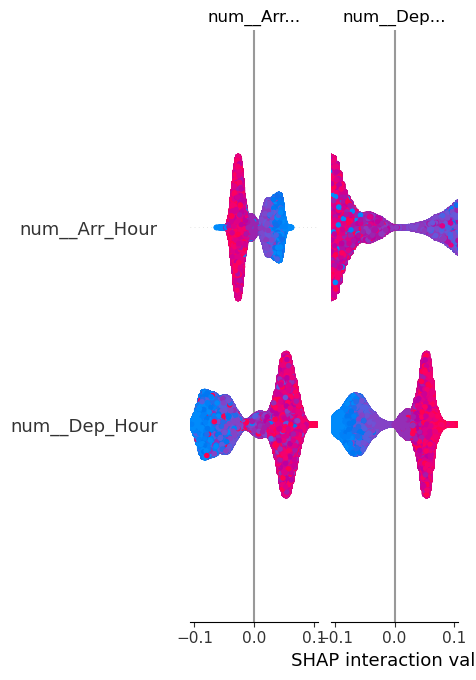

SHAP Summary Plot for Logistic Regression:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


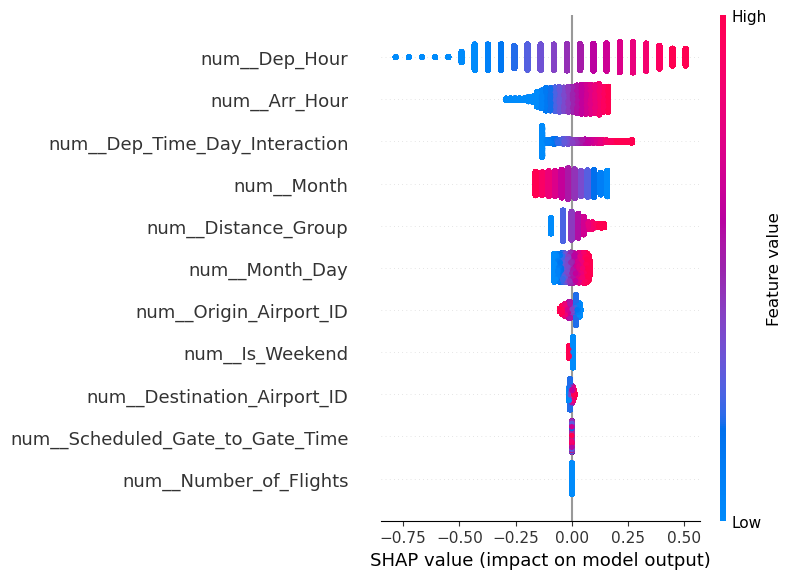

SHAP Summary Plot for Gradient Boosting:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


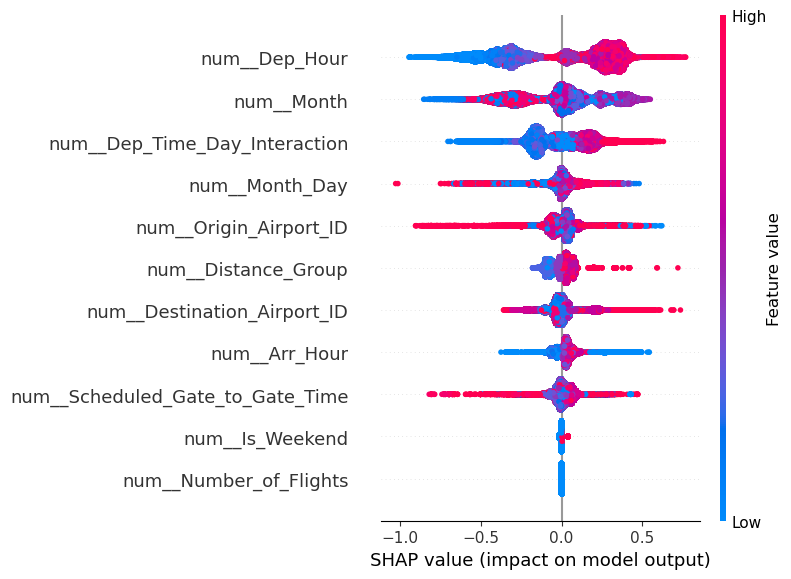

[18:35:30] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


SHAP Summary Plot for XGBoost:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


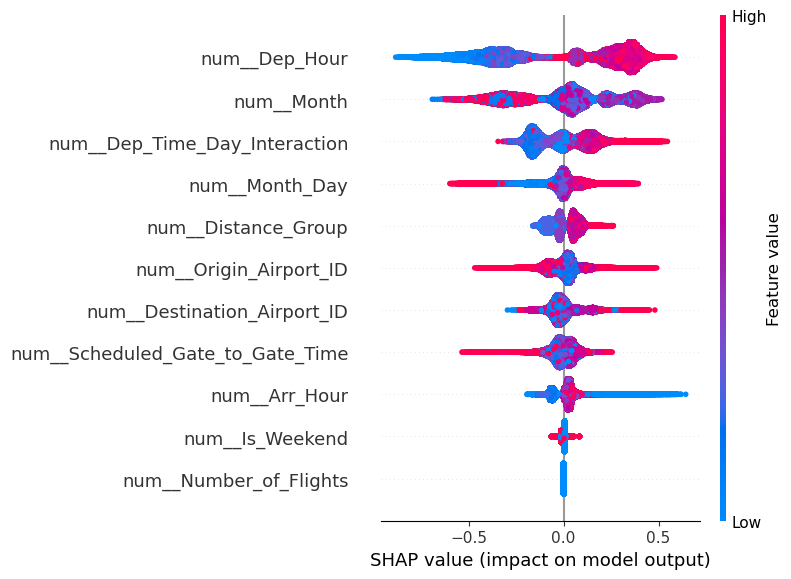

SHAP Summary Plot for LightGBM:


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


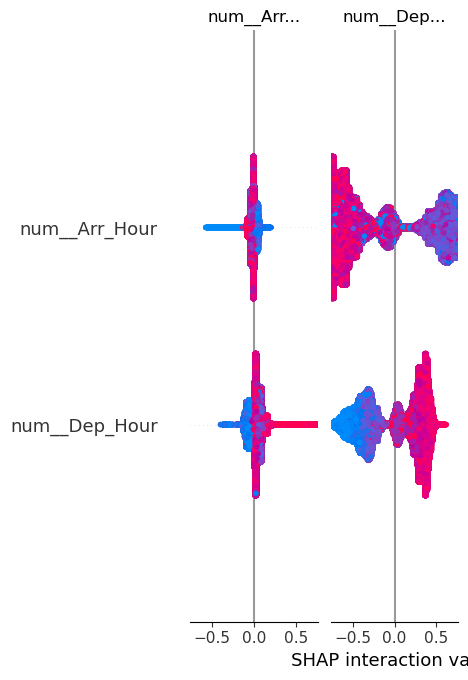

SHAP interpreter took: 2358.8938660621643 seconds


In [19]:
import shap
# Use a smaller sample of the test data
X_test_sample = X_test_preprocessed[:1000]

start_time = time.time()

# SHAP for RandomForest
explainer_rf = shap.Explainer(rf_model_best)
shap_values_rf = explainer_rf(X_test_preprocessed)

# Plot SHAP summary plot for RandomForest
print("SHAP Summary Plot for RandomForest:")
shap.summary_plot(shap_values_rf, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())

# SHAP for Logistic Regression
explainer_lr = shap.LinearExplainer(lr_model_best, X_train_preprocessed)
shap_values_lr = explainer_lr.shap_values(X_test_preprocessed)

# Plot SHAP summary plot for Logistic Regression
print("SHAP Summary Plot for Logistic Regression:")
shap.summary_plot(shap_values_lr, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())

# SHAP for Gradient Boosting
explainer_gb = shap.Explainer(gb_model_best)
shap_values_gb = explainer_gb(X_test_preprocessed)

# Plot SHAP summary plot for Gradient Boosting
print("SHAP Summary Plot for Gradient Boosting:")
shap.summary_plot(shap_values_gb, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())

# SHAP for XGBoost
explainer_xgb = shap.Explainer(xgb_model_best)
shap_values_xgb = explainer_xgb(X_test_preprocessed)

# Plot SHAP summary plot for XGBoost
print("SHAP Summary Plot for XGBoost:")
shap.summary_plot(shap_values_xgb, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())

# SHAP for LightGBM
explainer_lgb = shap.Explainer(lgb_model_best)
shap_values_lgb = explainer_lgb(X_test_preprocessed)

# Plot SHAP summary plot for LightGBM
print("SHAP Summary Plot for LightGBM:")
shap.summary_plot(shap_values_lgb, X_test_preprocessed, feature_names=preprocessor.get_feature_names_out())

print("SHAP interpreter took: %s seconds" % (time.time() - start_time))

In [38]:
import pickle

# Define the best model based on Evaluation metrics
best_model = xgb_model  

# Save the best model to a file
with open('best_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

print("Best model (XGBoost) saved successfully.")

Best model (XGBoost) saved successfully.


In [40]:
# Load the model from the file to ensure it was saved correctly
with open('best_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# Test the loaded model with a sample input
sample_input = X_test_preprocessed[:5]  
sample_prediction = loaded_model.predict(sample_input)
print("Sample predictions from the loaded model:", sample_prediction)

Sample predictions from the loaded model: [0 1 1 1 1]
